# Mouvement Brownien fractionnaire et dépendance sérielle

## Libraries

Usefull

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Scipy

In [2]:
from scipy.fft import fft
from scipy.special import gamma
from scipy.stats import stats, chi2, linregress, norm
from scipy.signal import periodogram
from scipy.linalg import cholesky
from scipy.optimize import minimize

Finance

In [3]:
import yfinance as yf
import pywt
from fbm import FBM

Others

In [4]:
import os

import json

import warnings

warnings.filterwarnings("ignore")

## Generate Fractionnal Brownian Motion

### Simulation

Cholesky

In [23]:
def generate_fbm_cholesky(n : int , hurst : float, epsilon = 1e-10) -> np.ndarray :
    """Generate a fractionnal Brownian Motion with cholesky method.

    Args:
        n (int): size of the process
        hurst (float): Hurst exponent of the process
        epsilon (type, optional): Defaults to 1e-10.

    Raises:
        ValueError: Not positive matrix

    Returns:
        np.ndarray: fBm process
    """

    # Definition of the time steps
    t = np.linspace(0, 1, n)

    # Creation of the covariance matrix
    cov_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            cov_matrix[i, j] = 0.5 * (t[i]**(2*hurst) + t[j]**(2*hurst) - np.abs(t[i] - t[j])**(2*hurst))

    cov_matrix += np.eye(n) * epsilon

    # Cholesky decomposition
    try:
        L = cholesky(cov_matrix, lower=True)

    except np.linalg.LinAlgError:

        raise ValueError("Cov Matrix is not positive definite.")

    # Generate random Gaussian variables
    z = np.random.normal(size=n)

    # Generate the fBm sample
    fbm_sample = np.array(L @ z)
    
    return fbm_sample


def fbm_to_price(fbm_sample: np.ndarray, S0: float, alpha: float = 1.0) -> np.ndarray:
    """
    Transforms a fractional Brownian motion sample into a price series
    starting at S0 with exponential (multiplicative) variations.

    fbm_sample: fBm values (starting around 0)
    S0        : desired initial price
    alpha     : volatility scale (or intensity of variations)
    """

    return S0 * np.exp(alpha * (fbm_sample - fbm_sample[0]))

FBM Library

In [6]:
def generate_fbm_series(n : int, hurst : float) -> np.ndarray:
    """Use of FBM library to generate a Fractionnal Brownian Motion with cholesky method.

    Args:
        n (int): size of the process.
        hurst (float): Given Hurst exponent of the process

    Returns:
        np.ndarray: fBm process.
    """

    f = FBM(n=n, hurst=hurst, length=1, method='cholesky')

    fbm_series = np.array(f.fbm())

    return fbm_series

Wood-Chan

In [7]:
def generate_fbm_wood_chan(n : int, hurst : float) -> np.array:
    """Generate a Fractionnal Brownian Motion by Wood Chan method.

    Args:
        n (int): size of the process
        hurst (float): Hurst exponent of the process

    Returns:
        np.ndarray: fBm process
    """
    
    # Generate frequencies
    freqs = np.fft.fftfreq(2 * n, 1 / n)
    freqs[0] = 1e-10  # Avoid division by zero for the first frequency

    # Compute the spectral density
    spectral_density = 0.5 * (np.abs(freqs) ** (-2 * hurst))
    spectral_density[0] = 0  # Set the DC component to zero

    # Generate random Gaussian variables (complex)
    random_gaussians = np.random.normal(size=2 * n) + 1j * np.random.normal(size=2 * n)

    # Apply the square root of the spectral density
    fft_process = random_gaussians * np.sqrt(spectral_density)

    # Perform the inverse FFT and extract the real part
    fGn = np.fft.ifft(fft_process).real[:n]

    # Cumulatively sum the fractional Gaussian noise to get the fBm
    fbm_sample = np.cumsum(fGn)

    return fbm_sample

Sellan Meyer Abry

In [8]:
def generate_fbm_sma(n: int, hurst: float) -> np.ndarray:
    """
    Generate a Fractional Brownian Motion (fBm) using the Sellan-Meyer-Abry method.

    Args:
        n (int): Size of the process.
        hurst (float): Hurst exponent of the process (0 < hurst < 1).

    Returns:
        np.ndarray: Simulated fBm process.
    """
    
    # Define the scale levels for the wavelet transform
    j_min = 0
    j_max = int(np.log2(n)) - 1

    
    # Initialize the fBm array
    fbm_sample = np.zeros(n)

    
    # Iterate over the scales
    for j in range(j_min, j_max + 1):
        
        # Define the step size at this scale
        step = 2 ** j

        # Generate the random coefficients for this scale
        coeff = np.random.normal(size=n // step + 1)

        # Compute the contribution to the fBm
        for k in range(len(coeff) - 1):
            start = k * step
            end = (k + 1) * step
            fbm_sample[start:end] += coeff[k] * (np.linspace(0, 1, step) ** hurst - np.linspace(0, 1, step).mean())

    
    # Normalize the fBm
    fbm_sample -= fbm_sample.mean()
    fbm_sample /= np.std(fbm_sample)

    
    # Compute the cumulative sum to get the final fBm
    fbm_sample = np.cumsum(fbm_sample)

    return fbm_sample

Generation of 1000 fBm with Cholesky

H_test = np.array(np.round(np.random.uniform(0.35, 0.65, 15), 4))


all_fBm = {h : [generate_fbm_series(1000, h) for _ in range(1000)] for h in H_test}

def convertir_ndarray(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError("Type non sérialisable")

with open("fBm generated.json", "w") as file:
    json.dump(all_fBm, file, indent=4, default=convertir_ndarray)

In [11]:
with open("fBm generated.json", "r") as file:
    paths = json.load(file)

<class 'dict'>
dict_keys(['0.6104', '0.4064', '0.4989', '0.4241', '0.4253', '0.4027', '0.5375', '0.6164', '0.5928', '0.6036', '0.555', '0.5389', '0.442', '0.5197', '0.4619'])


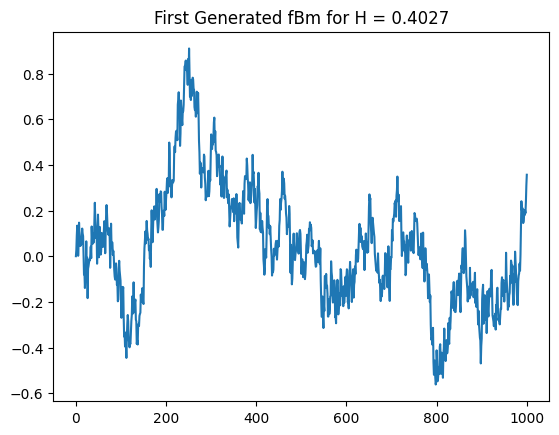

In [24]:
print(type(paths))
print(paths.keys())
plt.plot(paths["0.4027"][0])
plt.title("First Generated fBm for H = 0.4027")
plt.show()

### Bloomberg Data

In [24]:
def load_data(ticker : str, timeframe : str) -> pd.DataFrame:

    df =  pd.read_excel(f"Data\{timeframe}\{ticker}.xlsx", index_col="Date")

    df[f"{ticker} Log Return"] = np.log(df[ticker]/df[ticker].shift())

    #df[f"{ticker} Cumprod"] = (1 + df[f"{ticker} Log Return"]).cumprod() - 1

    return df.dropna()

In [88]:
df_test = load_data("AAPL", "Daily")

df_test = df_test.iloc[:-1]

In [68]:
df_test

,AAPL,AAPL Log Return
Date,,
2000-01-05,0.929,0.015185
2000-01-06,0.848,-0.091228
2000-01-07,0.888,0.046091
2000-01-10,0.873,-0.017036
2000-01-11,0.828,-0.052922
...,...,...
2024-12-24,258.200,0.011413
2024-12-26,259.020,0.003171
2024-12-27,255.590,-0.013331


## Estimation

Log Periodogramm

In [26]:
def logPeriodo(fBm : np.ndarray, m1=None, m2=None, llplot=False) -> float:
    """
    Estimation du paramètre H en utilisant le log-périodogramme.

    m1, m2 : Plages de fréquences utilisées.
    llplot : Si True, réalise un plot log-log des fréquences et du spectre.

    Retourne : Estimation du paramètre H.
    """
    
    n = len(fBm)
    
    # Convertir le fBm en fGn (différences successives)
    fGn = np.diff(fBm, prepend=0)

    # Par défaut, plages des fréquences
    if m1 is None:
        m1 = 1
    if m2 is None:
        m2 = n // 2

    # Calcul du périodogramme et des fréquences de Fourier
    I_lambda = (np.abs(fft(fGn))**2) / (2 * np.pi * n)
    I_lambda = I_lambda[m1:m2]
    lambda_vals = (2 * np.pi * np.arange(m1, m2)) / n

    # Régression linéaire log-log
    log_lambda = np.log(lambda_vals)
    log_I_lambda = np.log(I_lambda)
    slope, intercept = np.polyfit(log_lambda, log_I_lambda, 1)

    # Estimation de H
    H = 0.5 * (1 - slope)

    # Affichage du plot log-log
    if llplot:
        plt.figure(figsize=(8, 5))
        plt.scatter(log_lambda, log_I_lambda, label="Données log-log")
        plt.plot(log_lambda, slope * log_lambda + intercept, color="red", label=f"Régression : H={H:.4f}")
        plt.xlabel("log(Fréquences)")
        plt.ylabel("log(Périodogramme)")
        plt.title("Régression du log-périodogramme sur log-fréquences")
        plt.legend()
        plt.grid()
        plt.show()

    return H

In [79]:
hurst_1Y = df_test.groupby(pd.Grouper(freq="1Y"))['AAPL'].apply(logPeriodo)
hurst_5Y = df_test.groupby(pd.Grouper(freq="5Y"))['AAPL'].apply(logPeriodo)


hurst_1Y.iloc[6],  hurst_5Y.iloc[1]

(0.537297964165767, 0.5187222482088272)

In [58]:
def rolling_hurst(frq : str):
    return df_test.groupby(pd.Grouper(freq=frq))['AAPL'].apply(logPeriodo)

frequencies = ["1M", "3M", "6M", "Y", "3Y", "5Y"]

In [ ]:
for fq in frequencies:
    hurst_values = rolling_hurst(fq)
    df_test[f"H_{fq}_bis"] = hurst_values.reindex(df_test.index, method="ffill")  # Réindexation et ffill

print(df_test.head())

<AxesSubplot:xlabel='Date'>

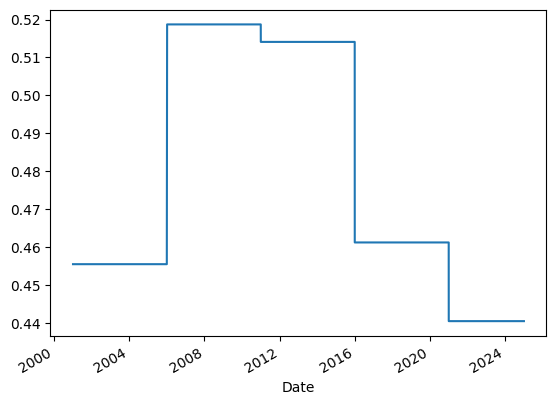

In [97]:
df_test["H_5Y_bis"].plot()

hn_periodo = {h : [logPeriodo(p) for p in all_fBm[h]] for h in H_test}

Wavelet Decomposition

In [12]:
def waveST(fBm : np.ndarray, j1=2, j2=None, llplot=False):
    """
    Estimation du paramètre H avec une décomposition en ondelettes.
    fBm : Série temporelle simulée.
    j1, j2 : Niveaux de résolution utilisés pour l'analyse.
    llplot : Si True, trace le graphe log-log des coefficients d'ondelettes.

    Retourne : Estimation de H et biais associé.
    """
    
    n = len(fBm)

    # Vérifier si n est une puissance de 2, sinon doubler les données
    if (np.log2(n) % 1) != 0:

        next_power_of_2 = int(2 ** np.ceil(np.log2(n)))

        fBm = np.concatenate([fBm, fBm[:next_power_of_2 - n]])

        n = len(fBm)

    # Initialiser j2
    if j2 is None:

        j2 = int(np.log2(n)) - 3

    # Convertir le fBm en fGn
    fGn = np.diff(fBm, prepend=0)

    # Décomposition en ondelettes (Daubechies, ordre 3)
    coeffs = pywt.wavedec(fGn, 'db3', level=j2)

    resolution = np.arange(j1, j2 + 1)

    # Calcul des scalogrammes (variances des coefficients)
    scalog = np.array([np.mean(np.array(coeffs[j]) ** 2) for j in resolution])

    # Moyennes et variances des biais théoriques (valeurs simulées)
    moy_eps = np.array([-0.83527463, -0.39006796, -0.18780535, -0.092044036,
                        -0.045553664, -0.022659505, -0.011300406, -0.0056428654,
                        -0.0028195982, -0.0014093405, -0.00070455559, -0.00035224913,
                        -0.0001761174, -8.8056909e-05, -4.4028006e-05, -2.2013891e-05])
    
    var_eps = np.array([3.4237147, 1.3423458, 0.5907403, 0.27710725, 0.13423536,
                        0.066069658, 0.032776787, 0.016324379, 0.0081462477,
                        0.0040691462, 0.0020335796, 0.0010165415, 0.00050820866,
                        0.00025408878, 0.00012704048, 6.3519251e-05])

    moy_eps = moy_eps[resolution - j1]
    var_eps = var_eps[resolution - j1]

    # Régression pondérée log-log
    log_scalog = np.log2(scalog) - moy_eps
    weights = 1 / var_eps
    slope, intercept = np.polyfit(resolution, log_scalog, 1, w=weights)

    # Calcul de H
    H = 0.5 * (1 - slope)

    # Calcul du biais
    A = resolution - np.mean(resolution)
    normA = np.dot(A, A)
    bias = np.dot(A, moy_eps) / normA

    # Tracé log-log
    if llplot:
        plt.figure(figsize=(8, 5))
        plt.scatter(resolution, log_scalog, label="Log2-scalogram", color="blue")
        plt.plot(resolution, slope * resolution + intercept, color="red",
                 label=f"Régression : H={H:.4f}")
        plt.xlabel("Résolutions log2")
        plt.ylabel("Log2-scalogram corrigé")
        plt.title("Régression du scalogramme sur les résolutions")
        plt.legend()
        plt.grid()
        plt.show()

    return H

hn_waveST = {h : [waveST(p) for p in all_fBm[h]] for h in H_test}

Whittle Likelyhood

In [13]:
def spdFGN(Htry : float, n : int) -> np.ndarray:
    """Calcule la densité spectrale normalisée du fGn à des fréquences de Fourier.

    Args:
        Htry (float): Valeur du paramètre H pour lequel calculer la densité spectrale.
        n (int): Longueur de la série temporelle.

    Returns:
        np.ndarray: Densité spectrale.
    """
    
    alpha = 2 * Htry + 1
    
    nstar = (n - 1) // 2
    
    clambda = (np.sin(np.pi * Htry) * gamma(alpha)) / np.pi

    spd = np.zeros(nstar)

    for k in range(1, nstar + 1):
        lambda_k = (2 * np.pi * k) / n
        sum_term = np.sum(np.abs(2 * np.pi * np.arange(-300, 301) + lambda_k) ** (-alpha))
        spd[k - 1] = clambda * (1 - np.cos(lambda_k)) * sum_term

    # Renormalisation de spd
    theta = np.exp((2 / n) * np.sum(np.log(spd)))
    
    spd /= theta

    return spd

In [14]:
def whittle_likelihood(Htry : float, perio : np.ndarray, n : int) -> float:
    """Fonction de vraisemblance Whittle à minimiser.

    Args:
        Htry (float): Valeur du paramètre H.
        perio (np.ndarray):  Périodogramme de la série temporelle.
        n (int): Longueur de la série temporelle.

    Returns:
        float: Estimateur de wittle par vraissenblance.
    """
    
    spd = spdFGN(Htry, n)

    return (4 * np.pi / n) * np.sum(perio / spd)

In [15]:
def whittle_estimator(fBm : np.ndarray, Hprel=0.5) -> float:
    """Estimateur de Whittle pour le paramètre H.

    Args:
        fBm (np.ndarray): érie temporelle simulée.
        Hprel (float, optional): Estimation initiale de H.. Defaults to 0.5.

    Returns:
        float: _description_
    """
    
    # Convertir le fBm en fGn
    fGn = np.diff(fBm, prepend=0)
    n = len(fGn)
    nstar = (n - 1) // 2

    # Calcul du périodogramme
    perio = (np.abs(fft(fGn)) ** 2) / (2 * np.pi * n)
    perio = perio[:nstar]

    # Minimisation de la fonction de vraisemblance Whittle
    result = minimize(whittle_likelihood,
                      x0=Hprel,
                      args=(perio, n),
                      bounds=[(0.01, 0.99)])

    H = result.x[0]

    return H

hn_whittle = {h : [whittle_estimator(p) for p in all_fBm[h]] for h in H_test}

Discrete Variation (known parameter)

In [16]:
def piaH(a : list, H : float, i=0) -> float:
    """ Calcul de la fonction de covariance des variations discrètes du fBm.

    Args:
        a (list): Coefficient de filtrage
        H (float): Hurt exponent.
        i (int, optional): Indice pour lequel évaluer la covariance.. Defaults to 0.

    Returns:
        float: pi_a^H(i).
    """
    
    l = len(a) - 1
    
    mat = np.zeros((l + 1, l + 1))

    mat = [[-0.5 * a[q] * a[r] * abs(q - r + i) ** (2 * H) for r in range(l + 1)] for q in range(l + 1)]

    piaH = np.sum(mat)

    return piaH

In [17]:
def VaPk_known(fBm : np.ndarray, k=2, a=None, Hprel=0.6) -> float:
    """ Estimation du paramètre H en utilisant les k-èmes moments absolus des variations discrètes.

    Args:
        fBm (np.ndarray): Série temporelle simulée (fBm).
        k (int, optional):  Puissance des variations discrètes. Defaults to 2.
        a (list, optional): Filtre (initilaisé avec filtre de Daubechies d'ordre 4).
        Hprel (float, optional): Estimation préliminaire de H pour initialiser la minimisation. Defaults to 0.6.

    Returns:
        float: Estimation de H.
    """

    if a is None:
        a = [0.4829629, -0.8365163, 0.22414386, 0.12940952]  # Filtre de Daubechies (ordre 4)

    # Calcul des variations discrètes
    n = len(fBm)

    Va = np.convolve(fBm, a, mode='valid')

    # Moments absolus empiriques
    Ek = (2 ** (k / 2) * gamma(0.5 * k + 0.5)) / gamma(0.5)

    SNka = np.mean(np.abs(Va) ** k)

    # Paramètres pour la minimisation
    params = {"n": n, "k": k, "a": a, "SNka": SNka, "Ek": Ek}

    def Q(Hessai : float) -> float:
        """
        Fonction de coût pour minimiser le biais sur SNka.
        """

        pia0 = piaH(a, Hessai, 0)

        res = np.log(SNka) + Hessai * k * np.log(n) - np.log(pia0 ** (k / 2) * Ek)

        return abs(res)

    # Minimisation pour trouver H
    result = minimize(Q,
                      x0=Hprel,
                      bounds=[(0.01, 0.99)])

    H = result.x[0]

    return H

hn_VaPk_known = {h : [VaPk_known(p) for p in all_fBm[h]] for h in H_test}

Discrete Variation (unknown parameter)

In [18]:
def dilatation(a : list, m : int) -> np.ndarray:
    """
    Dilatation d'un filtre a par un facteur m.
    a : Filtre initial.
    m : Facteur de dilatation.
    """
    
    la = len(a)
    
    am = np.zeros((m - 1) * (la - 1) + la)  # Taille correcte pour éviter les conflits
    
    am[::m] = a

    return am

In [19]:
def VaPk_unknown(fBm : np.ndarray, k=2, a=None, M=5, llplot=False):
    """
    Estimation de H (OLS) par régression linéaire des moments absolus des variations discrètes.
    fBm : Série temporelle simulée.
    k : Puissance des moments (par défaut 2).
    a : Filtre (par défaut filtre de Daubechies d'ordre 4).
    M : Nombre maximum de dilatations.
    llplot : Si True, trace le graphique log-log.
    """
    
    if a is None:
        a = [0.4829629, -0.8365163, 0.22414386, 0.12940952]  # Filtre de Daubechies (ordre 4)

    N = len(fBm)
    la = len(a)

    # Calcul des moments pour chaque dilatation
    SNkam = []
    
    for m in range(1, M + 1):

        am = dilatation(a, m)

        Va = np.convolve(fBm, am, mode='valid')

        SNkam.append(np.mean(np.abs(Va) ** k))

    # Régression linéaire log-log
    LN = np.log(SNkam)

    m_vals = np.log(np.arange(1, M + 1))

    slope, intercept = np.polyfit(m_vals, LN, 1)

    Hols = slope / k

    # Biais dû à la non-linéarité du logarithme
    mean_eps = np.array([-1 / (2 * (N - m * (la - 1))) for m in range(1, M + 1)])

    A = m_vals - np.mean(m_vals)
    
    bias = -np.dot(A, mean_eps) / (2 * np.dot(A, A))

    # Coefficient de mise à l'échelle
    Ek = (2 ** (k / 2) * gamma(0.5 * k + 0.5)) / gamma(0.5)
    
    pia0 = piaH(a, Hols, 0)
    
    thetaols = intercept
    
    Cols = N ** Hols / Ek ** (1 / k) / np.sqrt(pia0) * np.exp(thetaols / k)

    # Affichage log-log
    if llplot:
        plt.figure(figsize=(8, 5))
        plt.plot(m_vals, LN, 'o', label="Moments empiriques")
        plt.plot(m_vals, slope * m_vals + intercept, label=f"Régression : H={Hols:.4f}")
        plt.xlabel("log(m)")
        plt.ylabel("log(SN(k, a^m))")
        plt.title("Régression log-log des moments absolus")
        plt.legend()
        plt.grid()
        plt.show()

    return Hols

hn_VaPk_unknown = {h : [VaPk_unknown(p) for p in all_fBm[h]] for h in H_test}

Saving all

all_hn_meth = {
    "Log Periodogramm" : hn_periodo,
    "Wavelett Decompo" : hn_waveST,
    "Whittle Likelyhood" : hn_whittle,
    "Discrete Var known param" : hn_VaPk_known,
    "Discrete Var unknown param" : hn_VaPk_unknown
}

with open("All estimation.json", "w") as file:
    json.dump(all_hn_meth, file, indent=4)

In [34]:
with open("All estimation.json", "r") as file:
    all_hn_meth = json.load(file)

## Significance

In [20]:
def calculate_rho(H : float, i : int, u : int, v : int) -> float:
    """Calcule rho_H^(u,v)(i) selon la formule."""
    
    rho = (abs(i + u)**(2 * H) +
        abs(i - v)**(2 * H) -
        abs(i)**(2 * H) -
        abs(i + u - v)**(2 * H)
    ) / (2 * u * v)**H

    return rho

In [21]:
def calculate_variance(H : float, n : int, u=1, v=2) -> float:
    """Calcule la variance de l'estimateur en fonction de H."""
    
    log2 = np.log(2)
    sum_rho_squared = 0
    
    for i in range(-n // 2, n // 2):  # Assure un parcours des indices entiers
        rho_11 = calculate_rho(H, i, u, u)
        rho_22 = calculate_rho(H, i, v, v)
        rho_12 = calculate_rho(H, i, u, v)
        rho_21 = calculate_rho(H, i, v, u)
        
        sum_rho_squared += (rho_11**2 + rho_22**2 - rho_12**2 - rho_21**2)
    
    variance = sum_rho_squared / (2 * (log2**2) * n)
    
    return variance

In [22]:
def test_significance(Hn : list, H0 : float, estimation_method : str) -> pd.DataFrame:
    """Test de significiance sur H en fonction de H_test.

    Args:
        fBm (np.ndarray): Série temporelle.
        H (float): Hurst exponent de la série.
        H_test (float): Hurst exponent initiale.

    Returns:
        pd.DataFrame: résultat du test.
    """
    
    n = len(Hn)

    # Calcul de la variance théorique
    sigma2 = calculate_variance(H0, n)
    vol = np.sqrt(sigma2)

    # Calcul de la statistique de test
    Hbar = np.mean(Hn)
    Z = np.sqrt(n) * (Hbar - H0) / vol

    # Calcul de la p-valeur
    p_value = 2 * norm.sf(abs(Z))

    # Calcul de l'intervalle de confiance à 99%
    margin_error = 2.58 * vol / np.sqrt(n)

    ci_lower = max(0, Hbar - margin_error)
    ci_upper = min(1, Hbar + margin_error)

    # Collecte des résultats dans un dictionnaire
    results = pd.DataFrame({
        "Estimation Method" : [estimation_method],
        "H 0" : [round(H0, 4)],
        "H barre" : [round(Hbar, 4)],
        # "Variance": [round(sigma2, 4)],
        "Volatility": [round(vol, 4)],
        "Z-Statistic": [round(Z, 4)],
        "P-Value": [round(p_value, 4)],
        "CI Lower Bound": [round(ci_lower, 4)],
        "CI Upper Bound": [round(ci_upper, 4)],
        "H0 Decision": ["Reject H0" if p_value < 0.05 else "Accept H0"]
    })

    return results

### Results

In [61]:
H_test = [float(h) for h in list(all_hn_meth["Log Periodogramm"].keys())]

signif = []

for h in H_test:

    for meth, hn in all_hn_meth.items():

        df = test_significance(hn[str(h)], h, meth)

        signif.append(df)

res = pd.concat(signif)

In [62]:
def printRes(method : str, res = res, dataframe = True, value_counts = True) -> None:

    print(method)
    
    if value_counts:
        print(res[res["Estimation Method"] == method]["H0 Decision"].value_counts())

    if dataframe : 
        return res[res["Estimation Method"] == method]
    
    


for meth in all_hn_meth.keys():
    printRes(meth, dataframe=False)
    print("\n")

Log Periodogramm
H0 Decision
Reject H0    14
Accept H0     1
Name: count, dtype: int64


Wavelett Decompo
H0 Decision
Reject H0    15
Name: count, dtype: int64


Whittle Likelyhood
H0 Decision
Reject H0    9
Accept H0    6
Name: count, dtype: int64


Discrete Var known param
H0 Decision
Accept H0    15
Name: count, dtype: int64


Discrete Var unknown param
H0 Decision
Accept H0    13
Reject H0     2
Name: count, dtype: int64




### Tests on Real data

In [ ]:
def process_assets(tickers, start_date):
    # DataFrame pour stocker les résultats
    results = pd.DataFrame()

    for ticker in tickers:

        # Récupérer les données de l'actif
        data = load_data(ticker, "Daily")[ticker]
        
        # Calcul pour Log Quad Returns
        H_log_quad = logPeriodo(data, llplot=False)
        test_log_quad = test_significance(data["Log Quad Returns"], H_log_quad)

        test_log_quad["Type"] = ["Log Quad Returns"]
        test_log_quad["Ticker"] = [ticker]

        # Calcul pour Prices
        H_price = logPeriodo(data, prices=True, llplot=False)
        test_price = test_significance(data["Price"], H_price)

        test_price["Type"] = ["Price"]
        test_price["Ticker"] = [ticker]

        # Construire une DataFrame avec un double indice
        results = pd.concat(
            [
                results,
                test_log_quad,
                test_price
            ]
        )    
    return pd.DataFrame(results).set_index(["Ticker", "Type"])

In [17]:
tickers = ["df-USD", "ETH-USD", "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NFLX", "NVDA", "BRK-B", "V", "JPM", "PG", "DIS", "MA", "PEP", "KO", "INTC", "CSCO"]

results_df = process_assets(tickers, "2020-01-01")

results_df[results_df["H0 Decision"] == "Reject H0"]

,,Hurst Coef,Variance,Volatility,Z-Statistic,P-Value,CI Lower Bound,CI Upper Bound,H0 Decision
Ticker,Type,,,,,,,,
BTC-USD,Price,0.5779,0.0010,0.0313,2.4899,0.0128,0.5166,0.6392,Reject H0
GOOGL,Log Quad Returns,0.6512,0.0011,0.0336,4.5041,0.0000,0.5854,0.7169,Reject H0
META,Log Quad Returns,0.5745,0.0014,0.0370,2.0101,0.0444,0.5019,0.6471,Reject H0
JPM,Log Quad Returns,0.5738,0.0013,0.0363,2.0332,0.0420,0.5027,0.6450,Reject H0
MA,Log Quad Returns,0.5839,0.0013,0.0361,2.3264,0.0200,0.5132,0.6547,Reject H0


## Forcasting with Monte-Carlo

Load Daily Data and verify Size and Null values

In [81]:
assets = {asset.split(".xlsx")[0] : pd.read_excel(f"Data\Daily\{asset}", index_col="Date") for asset in os.listdir("Data\Daily")}

for name, df in assets.items():
    print(name, len(df))

    if(df.isnull().sum().sum() > 0 or (df == 0).sum().sum() > 0):
        print(df.info())    

AAPL 6289
BNP 6396
BRENT 6422
BTC 3767
CAC 6396
ETH 1799
EURUSD 6523
F10Y 2413
GAS 6284
GBPEUR 6522
GERM10Y 6514
GOLD 6508
GS 6289
LVMH 6396
MSFT 6289
NSQ 6289
SOL 369
SPY 6289
TSLA 3654
TTE 6396
USDJPY 6523
UST10Y 6519
XOM 6289


In [154]:
def annualized_vol(stock : pd.Series):

    return np.std(np.log(stock/stock.shift(1)).dropna()) * np.sqrt(252)

assets_s0_H = {
    name : [df.to_numpy()[-1],
            annualized_vol(df[name]),
            logPeriodo(df[name].to_list()),
            whittle_estimator(df[name].to_list()),
            waveST(df[name].to_list()),
            VaPk_known(df[name].to_list()),
            VaPk_unknown(df[name].to_list())
            ] for name, df in assets.items()
}

df_H_estimation = pd.DataFrame(assets_s0_H,
                               index = ["S0", "Vol", "LogPeriodo", "Whittle", "WaveST", "VaPk_known", "VaPk_unknown"]
                               ).T.astype(float)

df_H_estimation

,S0,Vol,LogPeriodo,Whittle,WaveST,VaPk_known,VaPk_unknown
AAPL,245.0750,0.400687,0.466124,0.492751,0.678488,0.010000,0.470925
BNP,59.1300,0.364693,0.496146,0.490088,0.734321,0.010586,0.510448
BRENT,76.0800,0.365669,0.483273,0.483486,0.506950,0.010000,0.473697
BTC,97142.9500,0.906583,0.500889,0.504140,0.683246,0.010000,0.491828
CAC,7365.2500,0.219944,0.479842,0.482949,0.984315,0.010000,0.479522
ETH,3491.9050,0.818092,0.515497,0.504424,0.605031,0.010000,0.530341
EURUSD,1.0306,0.092190,0.488681,0.500000,1.222178,0.560900,0.489428
F10Y,92.3410,0.068992,0.502449,0.501927,1.445803,0.118865,0.513447
GAS,3.6930,0.583847,0.462479,0.475730,0.495754,0.200321,0.469729
GBPEUR,1.2031,0.078586,0.501106,0.500000,1.309494,0.569590,0.499125


In [155]:
df_H_estimation.drop(columns=["WaveST", "VaPk_known"], inplace=True)

In [204]:
df_H_estimation["Mean H"] = df_H_estimation.iloc[:, 2:].mean(axis=1)
df_H_estimation

,S0,Vol,LogPeriodo,Whittle,VaPk_unknown,Mean H
AAPL,245.0750,0.400687,0.466124,0.492751,0.470925,0.476600
BNP,59.1300,0.364693,0.496146,0.490088,0.510448,0.498894
BRENT,76.0800,0.365669,0.483273,0.483486,0.473697,0.480152
BTC,97142.9500,0.906583,0.500889,0.504140,0.491828,0.498952
CAC,7365.2500,0.219944,0.479842,0.482949,0.479522,0.480771
ETH,3491.9050,0.818092,0.515497,0.504424,0.530341,0.516754
EURUSD,1.0306,0.092190,0.488681,0.500000,0.489428,0.492703
F10Y,92.3410,0.068992,0.502449,0.501927,0.513447,0.505941
GAS,3.6930,0.583847,0.462479,0.475730,0.469729,0.469313
GBPEUR,1.2031,0.078586,0.501106,0.500000,0.499125,0.500077


In [163]:
def get_H_vol_S0(asset):

    vol = df_H_estimation.loc[asset, "Vol"]
    
    H = df_H_estimation.loc[asset, "Mean H"]
    
    s0 = df_H_estimation.loc[asset, "S0"]

    return H, vol, s0

def generate_after_s0(asset : str, all_paths : dict, n=100000, length = 252):

    H, vol, s0 = get_H_vol_S0(asset)

    paths = np.empty((n,length))

    for i in range(n):

        fbm = generate_fbm_cholesky(length, H)

        paths[i, : ] = fbm_to_price(fbm, s0, vol)

    all_paths[asset] = paths

In [165]:
monte_carlo = {}

generate_after_s0("AAPL", monte_carlo)

In [166]:
def convertir_ndarray(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError("Type non sérialisable")

with open("AAPL Monte Carlo.json", "w") as file:
    json.dump(monte_carlo, file, indent=4, default=convertir_ndarray)

In [206]:
def mean_plot(stock : str, monte_carlo = monte_carlo):
    mean_aapl = np.mean(monte_carlo[stock], axis=0)

    plt.plot(mean_aapl, c = "black")

    plt.title(f"Monte Carlo forcasting {stock}")
    plt.xlabel("Forcasted price")
    plt.ylabel("Days")
    plt.grid(alpha=0.7)
    plt.show()

In [209]:
def random_plots(stock : str, monte_carlo = monte_carlo, length = 1000):
    rand_paths = np.empty((length,252))

    plt.figure(figsize=(20,12))

    for i in range(length):
        rand = np.random.randint(0, 1000)
        color = np.random.rand(3,)
        plt.plot(monte_carlo[stock][rand], c = color, alpha=0.7)

        rand_paths[i, :] = monte_carlo[stock][rand]

    mean_rand_paths = np.mean(rand_paths, axis=0)
    plt.plot(mean_rand_paths, c = "black")

    plt.title(f"Monte Carlo forcasting {stock}")
    plt.xlabel("Forcasted price")
    plt.ylabel("Days")
    plt.grid(alpha=0.7)
    plt.show()

    print(mean_rand_paths[-1])

In [189]:
indexes = list(df_H_estimation.index)
indexes.remove("AAPL")

for stock in indexes:
    generate_after_s0(stock, monte_carlo, n=5000)
    print(stock)

BNP
BRENT
BTC
CAC
ETH
EURUSD
F10Y
GAS
GBPEUR
GERM10Y
GOLD
GS
LVMH
MSFT
NSQ
SOL
SPY
TSLA
TTE
USDJPY
UST10Y
XOM


In [190]:
with open("Monte Carlo 2025.json", "w") as file:
    json.dump(monte_carlo, file, indent=4, default=convertir_ndarray)

In [205]:
aapl_forecast = {}

generate_after_s0("AAPL", aapl_forecast, 1000)

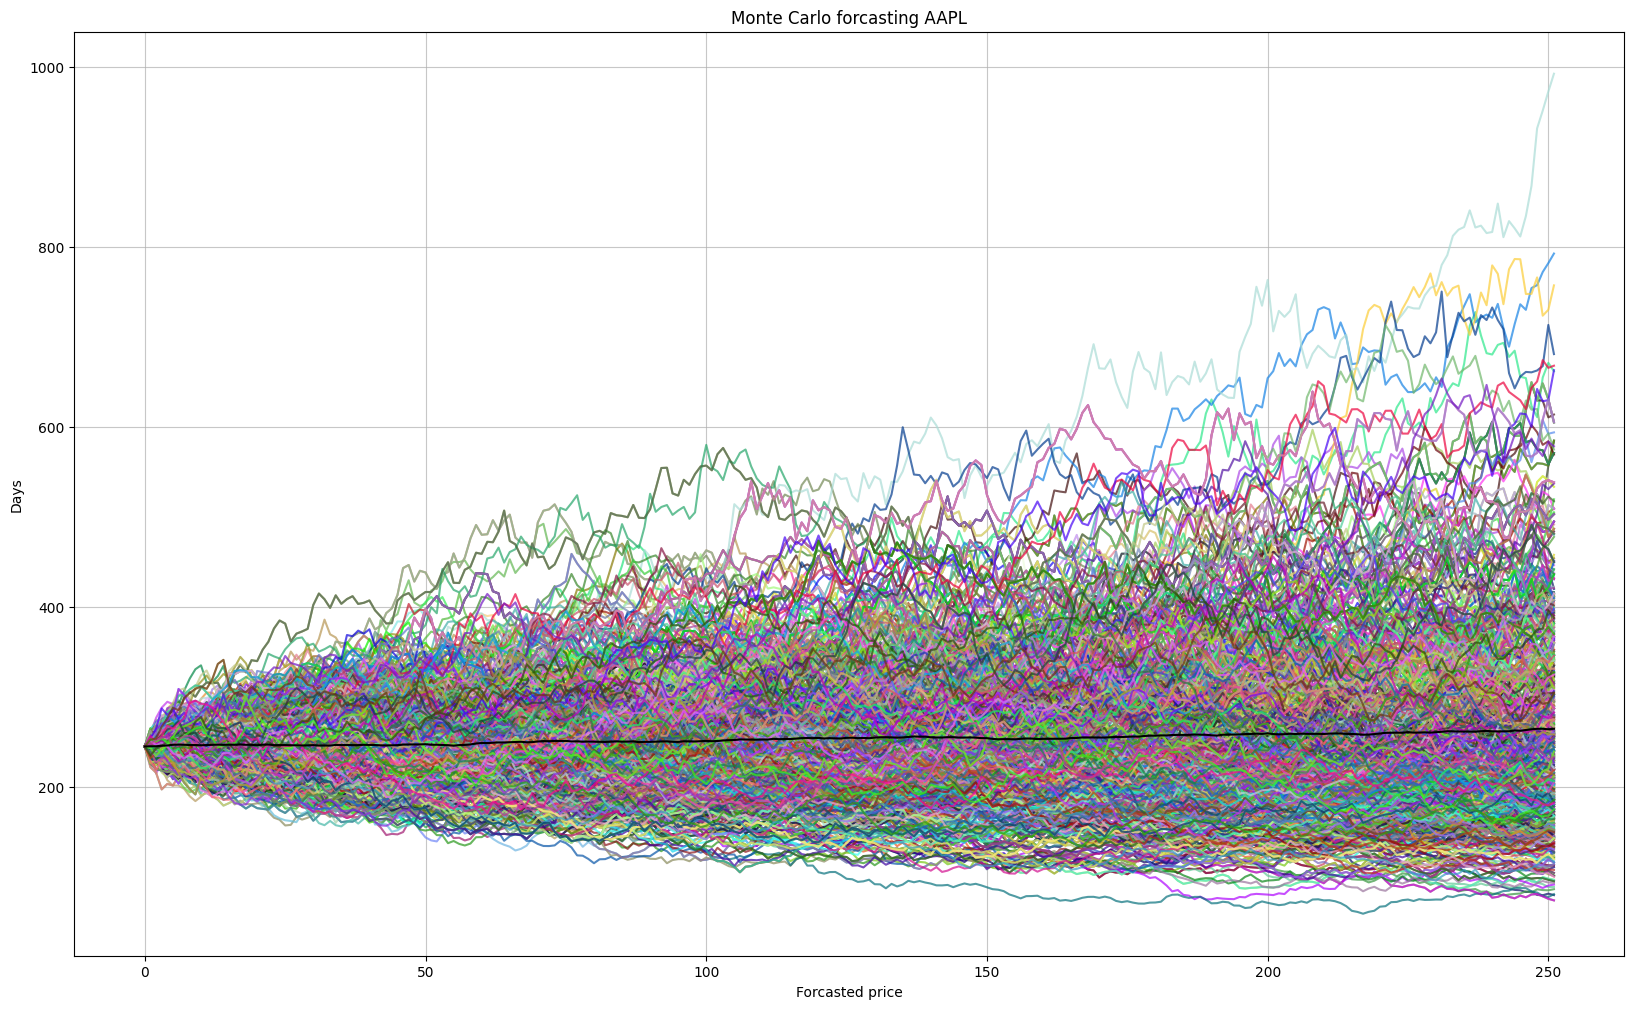

264.7778686463517


In [212]:
random_plots("AAPL", monte_carlo=aapl_forecast)

## Metrics distribution

In [67]:
def calculate_vol(series : pd.Series, window : int) :
    return series.rolling(window).std() * np.sqrt(252)

def calculate_sharpe(series : pd.Series, window : int, risk_free_rate=0):
    excess_return = series - risk_free_rate
    rolling_mean = excess_return.rolling(window=window).mean()
    rolling_std = excess_return.rolling(window=window).std()
    sharpe_ratio = rolling_mean / rolling_std
    return sharpe_ratio

def calculate_maxDrawdown(series : pd.Series, window : int):
    rolling_max = series.rolling(window=window).max()
    drawdown = series / rolling_max - 1
    max_drawdown = drawdown.rolling(window=window).min()
    return max_drawdown

def calculate_Log_Return(series : pd.Series):
    return np.log(series / series.shift(1)).dropna()

def calculate_Cummul_Return(series : pd.Series):
    return (1 + np.log(series / series.shift(1))).cumprod() - 1
        

def calculate_hurst(series : pd.Series, window : int, hurst_method):
    return series.rolling(window=window).apply(hurst_method, raw=True)

def asset_metrics(asset : str) -> pd.DataFrame:

    df = pd.read_excel(f"Data\Daily\{asset}.xlsx", index_col="Date")

    df["Log Return"] = calculate_Log_Return(df[asset])
    df["MaxDrawdown"] = calculate_maxDrawdown(df[asset], 252)
    df["Sharpe"] = calculate_sharpe(df[asset], 252)
    df["Volatility"] = calculate_vol(df["Log Return"], 2)
    df["Hurst"] = calculate_hurst(df["Return"], 252, logPeriodo)

    return df.dropna()